# Classical method exploration on counting cells

This code is used to explore and visualise different versions of cell counting techniques to find the best method for cell counting.

Developed by Turlagh Clancy 14/11/2023

In [20]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def process_TIF(filepath): # Function to get from tif file to grayscale image, maybe should change imread to only get grayscale
    #tif file to RGB numpy array
    array = tiff.imread(filepath)
    #convert to greyscale
    gray_arr = convert_to_grayscale(array)
    return gray_arr

def convert_to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

def simple_background_subtraction(frames, threshold=30, init_learning_rate=0.30, background_init=None):
    # Function to apply our background subtraction algorithm
    #   frames is a numpy array with dimensions (num_frames, width, height)
    #   threshold is a parameter that determines how close or far the pixel values have to differ from the background to be considered foreground
    #   learning_rate_scheduler is a function that returns the learning rate based on the frame number
    #   Background Init should be a numpy array of the background frame
    
    # Initialize array for the foreground
    num_frames, width, height = frames.shape
    grayscale_masks = np.zeros((num_frames, width, height), dtype=np.uint8)

    # Either choose the initialize background path or replace it with the average value of the frame
    if background_init is not None:
        if background_init.shape == (width, height):
            background_frame = background_init
        else:
            raise ValueError("The dimensions of the external background image do not match the input frames.")
    else:
        background_frame = frames[0]

    # Loop through each frame and compare it to the background frame
    for frame_num in range(0, num_frames):
        current_frame = frames[frame_num]

        # Calculate the difference between frame and background
        frame_diff = np.abs(current_frame - background_frame)
        grayscale_mask = (frame_diff > threshold).astype(np.uint8) * 255

        # Calculate the current learning rate using the scheduler
        if init_learning_rate is not None:
            current_learning_rate = init_learning_rate
        else:
            current_learning_rate = 0.05  # Default learning rate if no scheduler is provided

        # Update the background frame with the current learning rate
        background_frame = background_frame * (1 - current_learning_rate/(frame_num+1)) + current_frame * current_learning_rate/(frame_num +1)

        # Store the inverted grayscale mask in the result (foreground is black, background is white)
        grayscale_masks[frame_num] = grayscale_mask

    return grayscale_masks


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Background initalisation: Local background file exists, will load it


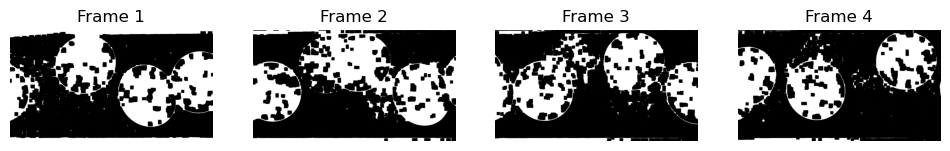

In [24]:
input_folder = r"..\Data\All_Sequences"
output_file = r"background_init.tif"

if os.path.exists(output_file):
    backgroundImage = convert_to_grayscale(tiff.imread(output_file))
    print("Background initalisation: Local background file exists, will load it")
else: 
    # backgroundImage = CreateBaseBackgroundImage(input_folder, output_file)
    print("Background initalisation: Background file does not exist, will generate it")

seq42 = process_TIF("../Data/All_Sequences/4-2.tif")
frames= simple_background_subtraction(seq42, threshold = 60 , init_learning_rate= 0.3, background_init= backgroundImage)

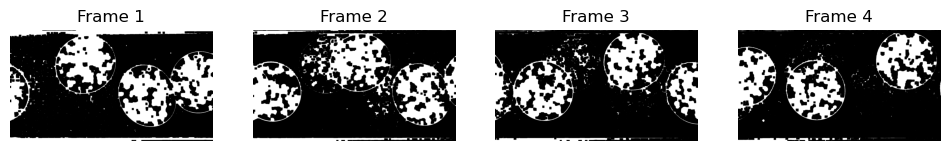

In [40]:
def apply_morphological_operations(frames, opening_kernel_size=5, closing_kernel_size=10, closing_iterations=3):
    num_frames, width, height = frames.shape
    processed_frames = np.zeros_like(frames, dtype=np.uint8)

    # Apply opening operation
    opening_kernel = np.ones((opening_kernel_size, opening_kernel_size), np.uint8)
    for frame_num in range(num_frames):
        frame = frames[frame_num]
        opened_frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, opening_kernel)
        processed_frames[frame_num] = opened_frame

    # Apply closing operation
    closing_kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)
    for _ in range(closing_iterations):
        for frame_num in range(num_frames):
            frame = processed_frames[frame_num]
            closed_frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, closing_kernel)
            processed_frames[frame_num] = closed_frame

    return processed_frames

processed_frames = apply_morphological_operations(frames, opening_kernel_size=500, closing_kernel_size=800, closing_iterations=5)

#Plot frames as sanity check
frames_to_display = closed_frames[:4]
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, frame in enumerate(frames_to_display):
    axes[i].imshow(frame, cmap='gray')
    axes[i].set_title(f'Frame {i + 1}')
    axes[i].axis('off')

plt.show()